# Statistics using Python

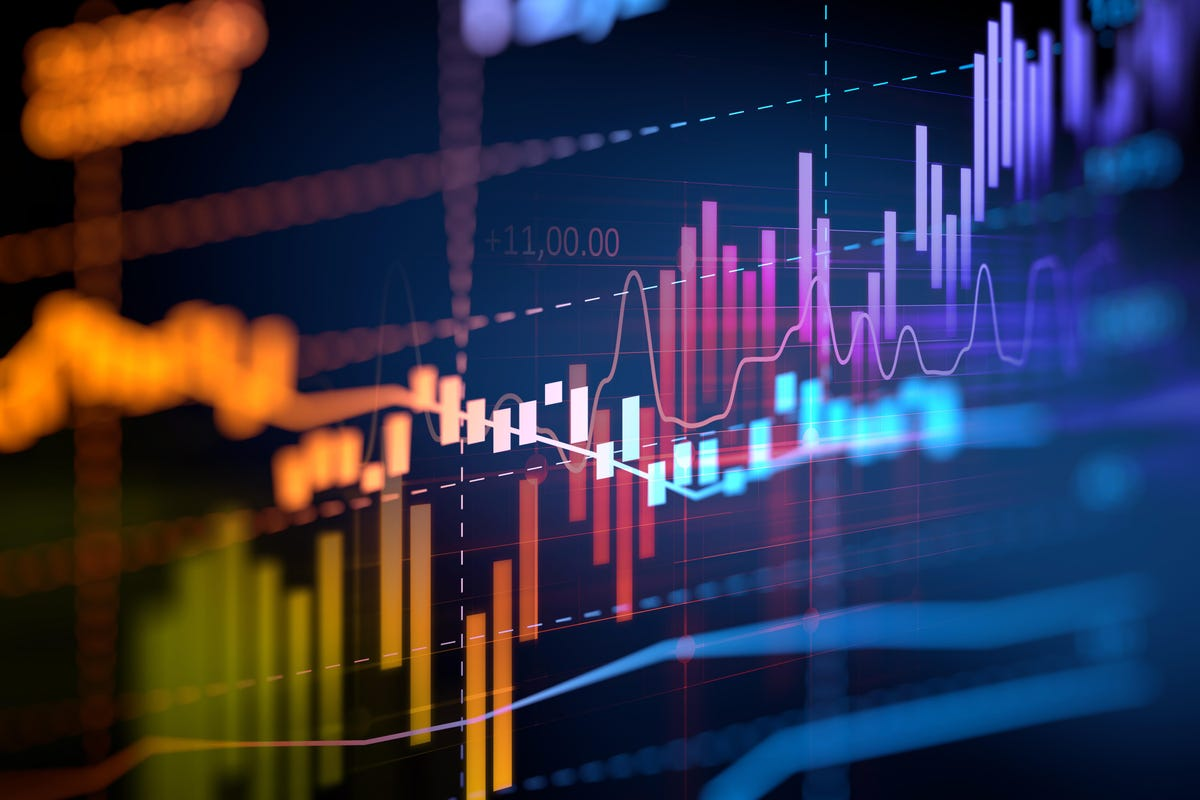

Image source: https://www.forbes.com/sites/kalevleetaru/2019/03/07/how-data-scientists-turned-against-statistics/?sh=3945e8eb257c

In [1]:
%matplotlib inline
!pip install --upgrade scipy
!pip install --upgrade statsmodels
!pip install matplotlib_venn
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import sys
import seaborn as sns
import warnings
from matplotlib_venn import venn2
from scipy import stats

sns.set_palette(['#00A99D', '#F5CA0C', '#B6129F', '#76620C', '#095C57'])
fill_color = '#F5CA0C'

# turn off data table rendering
pd.set_option('display.notebook_repr_html', False)
plt.style.use('ggplot')
# Ignores warnings to replace displot with histplot or distplot. Some of the options do not port over nicely and require
# some reworking. Leave the working code as is for now.
warnings.simplefilter(action='ignore', category=FutureWarning)

  Found existing installation: scipy 1.2.1
    Uninstalling scipy-1.2.1:


Could not install packages due to an EnvironmentError: [WinError 5] Access is denied: 'c:\\programdata\\anaconda3\\lib\\site-packages\\scipy\\cluster\\hierarchy.py'
Consider using the `--user` option or check the permissions.



  Using cached https://files.pythonhosted.org/packages/05/8e/8de486cbd03baba4deef4142bd643a3e7bbe954a784dc1bb17142572d127/packaging-21.3-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/40/69/4af412d078cef2298f7d90546fa0e03e65a032558bd85319239c72ae0c3c/scipy-1.7.3-cp37-cp37m-win_amd64.whl
  Found existing installation: packaging 19.0
    Uninstalling packaging-19.0:


Could not install packages due to an EnvironmentError: [WinError 5] Access is denied: 'c:\\programdata\\anaconda3\\lib\\site-packages\\packaging-19.0.dist-info\\INSTALLER'
Consider using the `--user` option or check the permissions.



  Stored in directory: C:\Users\tdepa\AppData\Local\pip\Cache\wheels\05\cb\36\dc8a4eb22f63d864d982a95c721e7c2a2946e1f6246ea3748e
Successfully built matplotlib-venn


C:\Users\tdepa\AppData\Roaming\Python\Python37\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
# Load 248 days of step data and vivofit goals
data = pd.read_csv('./data/garmin-vivofit.csv', index_col='date')
data.head()

           steps  goal  Unnamed: 3  Unnamed: 4
date                                          
4/25/2014   9936  4994         NaN         NaN
4/26/2014   7465  5294         NaN         NaN
4/27/2014   9437  5610         NaN         NaN
4/28/2014   8368  5946         NaN         NaN
4/29/2014  10254  6302         NaN         NaN

## Calculate the mean
The arithmetic mean is the most commonly used measure of central tendency. The Greek letter $\mu$ (mu) is used to represent the population mean. To calculate the mean, we sum up all values $x_0+x_1+x_n$ and divide it by the number of values $n$.

$$\mu= \frac{1}{n}\sum_{i=0}^n x_i$$


In [3]:
# Calculate the mean
x, n = 0.0, 0

for number_of_steps in data.steps:
    x += number_of_steps

n = len(data.steps)

mean = x / n
mean

8059.653225806452

In [4]:
# We can also let pandas use NumPy's mean function to do the job
data.steps.mean()

8059.653225806452

In [5]:
# Or we can call NumPy's mean function ourselves
np.mean(data.steps)

8059.653225806452

In [6]:
# Use pandas to get the mean for all columns at ones
data.mean()

steps         8059.653226
goal          7932.141129
Unnamed: 3            NaN
Unnamed: 4            NaN
dtype: float64

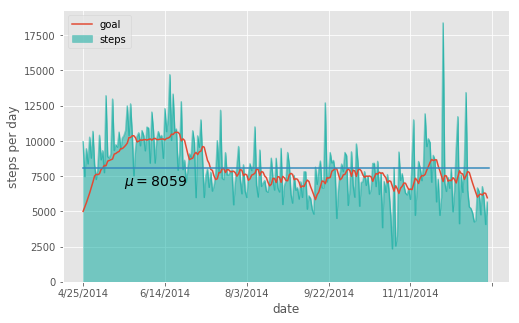

In [7]:
# Plot the mean, togehter with the steps and goal data
data.steps.plot(kind='area', color='#00A99D', alpha=.5, figsize=(8,5))
data.goal.plot(legend=True)
plt.plot([0, len(data.steps)],[mean, mean])
plt.ylabel('steps per day')
plt.text(25, mean-1200, r'$\mu=' + str(int(math.floor(mean))) + '$', fontsize=14)
plt.legend(loc='upper left')

## Calculate the median
The median is often a better measure of central tendency when we have extreme outliers. The median is the value in the middle after we sort the data. This is why outliers do not influence the median as much as they do the mean. If the number of observations $n$ is even, we have to take the mean of the two middle values. We calculate for a zero based index.


$$n\ is\ odd:\ \ x_{median}=x_{\frac{n-1}{2}}$$

$$n\ is\ even:\ \ x_{median}=\frac{x_\frac{n-2}{2}+x_\frac{n}{2}}{2}$$


In [8]:
# Again, we can let pandas use NumPy's median function to do the job
data.steps.median()

7810.0

In [9]:
# Or we can call NumPy's median function ourselves
np.median(data.steps)

7810.0

In [10]:
# Use pandas to get the median for all columns at ones
data.median()

steps         7810.0
goal          7619.5
Unnamed: 3       NaN
Unnamed: 4       NaN
dtype: float64

## Calculate the Mode
The mode is one or more values which occur most often in the series. This measure of central tendency is especially meaningful when you have a lot of repeated data points (like five-star ratings, day numbers). For the Garmin Vivofit data, however, this holds a problem, because we seldom have the same step count on a particular day. In that case we could categorize our data into range buckets, like 0-1000, 1000-2000 steps, and count the frequencies of the observations in the buckets. Choosing the right bucket size can be tricky, because we can obscure the data or miss the 'real' mode.

Mode: 6243.0 with bucket size 1000


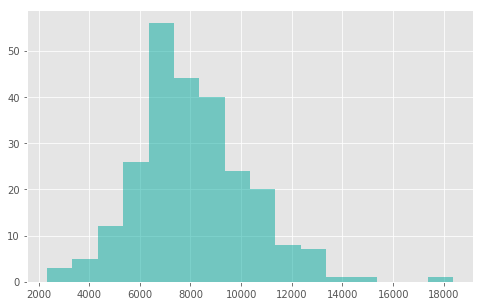

In [11]:
# Let's create a lambda that assigns a bucket of size 1000 steps
# to each of the step count in the data set
bucket_size = 1000
bucket_calculator = lambda x: int(x) / bucket_size * bucket_size

data['bucket'] = data.steps.apply(bucket_calculator)
bucket_min = data.bucket.min()
bucket_max = data.bucket.max()
bins = (bucket_max-bucket_min)/bucket_size

data.bucket.hist(color='#00A99D', alpha=.5, bins=int(bins), figsize=(8,5))

print ('Mode:', data.groupby('bucket').steps.count().idxmax(), 'with bucket size', bucket_size)

## Probability of Independent Events
First an exploration of independent events. This is where one event doesn't effect the other. If we flip a fair coin, te probability that the comes up heads or tails is for both 50%. Simply by intuition we know:

$$
P(Heads)=0.5\\
P(Tails)=0.5
$$

If we flip a biased (loaded, unfair) coin, the odds change. Let's say we have a coin that comes up tails 75% of the time.

$$
P(T)=0.75\\
P(H)=1.0-0.75=0.25
$$

This leads to a basic probability law that the probability of $A$ happening is equal to the probability of $1$ minus $A$ *not* happening, or $A'$ which is called the complement of $A$.

$$
P(A)=1.0-P(A')
$$


In [12]:
# Calculate the complement (where x is in the domain [0, 1])
p_complement = lambda x: 1.0 - x
p_complement(0.75)

0.25

### Mutual Exclusive Events
We call two events mutual exclusive or disjoint when they can't occur at the same time (flipping heads and tails with one coin). When A and B are disjoint, the probability of this happening is zero.

$$
P(A\cap B)=0
$$


## Intersection
If we are looking at the intersection ('and', $\cap$) between two independent events, we multiply their respective probabilities to get the combined probabaility. Let's say we flip the same fair coin twice, then each of the four possible outcomes are equaly likely. The probability of flipping heads twice (heads *and* heads):

$$
P(H\cap H)=P(H)\cdot P(H)=0.5\cdot0.5=0.25
$$

What if we flipped a biased coin twice with a probability of 65% landing on tails. What is the probability that we flip heads twice in a row.

$$
P(H\cap H)=P(H)\cdot P(H)=0.35\cdot0.35=0.1225
$$


### Multiplication Rule
The specific multiplication rule for *independent* and *dependent* events can be generalized as follows.

$$
P(A\cap B)=P(B\ |\ A)\cdot P(A)
$$

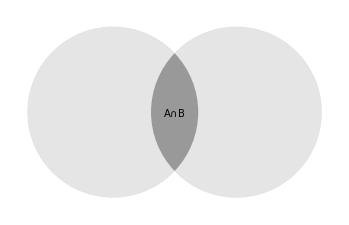

In [13]:
# Intersection / And
v = venn2(subsets=(1, 1, 0.2), 
          set_labels=('',''), set_colors=('k', 'k'))
v.get_patch_by_id('10').set_color('silver')
v.get_patch_by_id('01').set_color('silver')
v.get_label_by_id('10').set_text('')
v.get_label_by_id('01').set_text('')
v.get_label_by_id('11').set_text('A$\cap$B')
plt.show()

In [14]:
# Specific multiplication rule for independent events
p_and = lambda a, b: a * b
p_and(0.35, 0.35)

0.12249999999999998

## Union
If we need a union ('or', $\cup$) of one or more possible outcomes, we add their respective probabilities to arrive ad the combined probability. For instance; we flip a biased coin, with a 55% chance of heads, three times. What is the probability that we get heads only once? First we need to know what the probability of the combination head, tails and tails for a single event. Since we flip three times, we need to add all the different possibilities of flipping heads ones (HTT, HTH, HHT):

$$
P(H,T,T)=P(H)\cdot P(T)\cdot P(T)\\
0.55\cdot0.45\cdot0.45=0.1114
$$

Now we still need to add up all the three possible outcomes of flipping heads ones 

$$
P(HTT\cup HTH\cup HHT)
$$

These all have the same probability of $0.1114$:

$$
0.1114+0.1114+0.1114=0.3341
$$


### Addition Rule
The union of **mutual exclusive** events can be generalized as follows:

$$
P(A\cup B)=P(A)+P(B)
$$

If we account for overlap (not mutual exclusive) we must subtract one probability of A and B or else it would be added twice. The general form becomes:

$$
P(A\cup B)=P(A)+P(B)-P(A\cap B)
$$

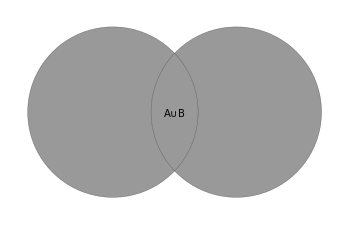

In [15]:
# Union / Or with overlap
v = venn2(subsets=(1, 1, 0.2), 
          set_labels=('',''), set_colors=('k', 'k'))
v.get_patch_by_id('10').set_color('k')
v.get_patch_by_id('01').set_color('k')
v.get_label_by_id('10').set_text('')
v.get_label_by_id('01').set_text('')
v.get_label_by_id('11').set_text('A$\cup$B')
plt.show()

## Bayes' Theorem
It is said that the Reverend Thomas Bayes developed his rule on inverse probability while he was trying to prove the existence of God somewhere around 1740. He came up with a method for calculating the probability of an event occurring given that another event has occurred. Starting out with the prior probability (or believe) $P(A)$, when given a likelihood) $P(B\ |\ A)$ and evidence $P(B)$ we arrive at the posterior probability $P(A\ |\ B)$. Bayes Rule proves to be a powerful tool and is widely used in diverging areas like economics, artificial intelligence, medicine, journalism, military, just to name a few. Most spam filters use Bayes Rule in one way or another. The Bayes' Theorem formula is, posterior = likelihood times prior, over evidence:

$$
P(A\ |\ B)=\frac{P(B\ |\ A)\cdot P(A)}{P(B)}
$$

The practical power of Bayes Rule is that we often can't find the posterior directly, yet we do know the likelihood of the test and $P(A)$.

An example; What is the chance of someone having COPD (a life-threatening lung disease) given he or she is a smoker - $P(A|B)$. This statistic is hard to figure out, but we do know from medical studies the probability of someone being a smoker given that he/she has COPD - $P(B|A)$. We also know $P(B)$ - the probability that a person is a smoker and $P(A)$ - the chance that someone has COPD. The figures below are rough estimations: 

$$
P(A)=0.07\ \small{having\ COPD}\\
P(B)=0.18\ \small{smokers}\\
P(B\ |\ A)=0.85\ \small{is\ or\ was\ smoker\ and\ given\ COPD\ diagnosis}
$$

What is the probability of someone having COPD given the person is or was a smoker?:

$$
P(A\ |\ B)=\frac{0.85\cdot 0.07}{0.18}=0.33
$$

In [16]:
# Calculate posterior probability
likelihood = 0.85
prior = 0.07
evidence = 0.18

posterior = (likelihood * prior) / evidence
posterior

0.3305555555555556

### Test Accuracy Example
Where Bayes' Rule shines is when we have evidence (for instance a test result) which is not 100% accurate. Let's say we have a test for detecting cancer. The probability of this test returning a positive result given the person has cancer is 99% (called the [sensitivity](http://en.wikipedia.org/wiki/Sensitivity_and_specificity)). The specificity is 93% and denotes the probability of having a negative test result given the person has no cancer. The cancer prevalence is 1% (proportion of people having cancer of the total population).

$$
P(C)=0.10\ \small{prevalence}\\
P(Pos\ |\ C)=0.99\ \small{sensitivity}\\
P(Neg\ |\ C')=0.93\ \small{specitivity}\\
$$

From these, we can compute the complements:

$$
P(C')=1-0.10=0.90\\
P(Neg\ |\ C)=1-0.99=0.01\\
P(Pos\ |\ C')=1-0.93=0.07\\
$$

Now a random person is picked, took the test, and the test is positive. What is the probability that this person has the disease or not given the test was positive?

$$
P(C\cap Pos)=P(Pos\ |\ C)\cdot P(C)=0.99\cdot 0.10=0.099\\
P(C'\cap Pos)=P(Pos\ |\ C')\cdot P(C')=0.07\cdot 0.90=0.063\\
P(Pos)=0.099+0.063=0.162\\
$$

So our answers are:

$$
P(C\ |\ Pos)=\frac{0.099}{0.162}=0.611\\
P(C'\ |\ Pos)=\frac{0.063}{0.162}=0.389\\
$$

In [17]:
# Calculate the probability having cancer or not 
# given a positive test result
prevalence = 0.10
sensitivity = 0.99
specitivity = 0.93

c_pos = sensitivity * prevalence
no_c_pos = (1-specitivity) * (1-prevalence)
normalizer = c_pos + no_c_pos

print('Probabilities given a positive test result:')
print('Cancer:', c_pos / normalizer)
print('No cancer', no_c_pos / normalizer)

Probabilities given a positive test result:
Cancer: 0.6111111111111113
No cancer 0.3888888888888887


## Data
The data is a set of ten salaries, as used in the Udacity course 'Intro to Descriptive Statistics' lesson 4 on measures of variability.

In [18]:
data = pd.DataFrame({'salaries': 
                     [33219, 36254, 38801, 46335, 46840, 
                      47596, 55130, 56863, 78070, 88830]})
data

   salaries
0     33219
1     36254
2     38801
3     46335
4     46840
5     47596
6     55130
7     56863
8     78070
9     88830

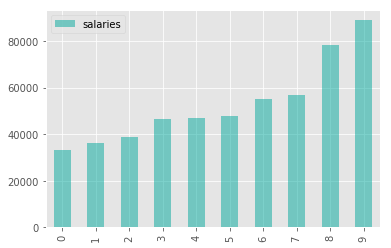

In [19]:
data.plot(kind='bar', color='#00A99D', alpha=.5)

## Calculate the Variance
The variance of a data set describes the average of the squared differences from the mean. In other words, it is a measure of how far each value in the data set is from the mean. The symbol for the variance of a population is $\sigma^2$ (sigma squared) and for a sample we use $s^2$. We calculate the variance by summing the squared difference from the mean for each value. For the population, we divide by the number of values $n$ in the data set.

$$population\ variance:\ \sigma^2=\frac{1}{n}\sum_{i=0}^n(x_i-\mu)^2$$

For the sample we divide the summed up values by the degrees of freedom $n-1$ (also called Bessel's correction). We use $\bar{x}$ (x bar) to symbolize our sample mean.

$$sample\ variance:\ s^2=\frac{1}{n-1}\sum_{i=0}^n(x_i-\bar{x})^2$$

In [20]:
# To calculate the population variance
n = len(data.salaries)

# first calculate the mean
mean = data.salaries.mean()

# Sum up the squared differences from the mean
squared_deviations = 0
for v in data.salaries:
    squared_deviations += (v - mean) ** 2

population_variance = squared_deviations / n
population_variance

291622740.36

In [21]:
# To calculate the variance if we only have a sample
# First calculate the degrees of freedom (apply Bessel's correction)
dof = n - 1
sample_variance = squared_deviations / dof
sample_variance

324025267.0666667

In [22]:
# Of course we can use pandas to let NumPy do the job for us
# The ddof parameter stands for Delta Degrees of Freedom
population_variance = data.salaries.var(ddof=0)
sample_variance = data.salaries.var() # ddof=1 by default in pandas

population_variance, sample_variance

(291622740.36, 324025267.0666667)

In [23]:
# Or call the NumPy var function ourselves
population_variance = np.var(data.salaries) # ddof=0 by default in NumPy
sample_variance = np.var(data.salaries, ddof=1)

population_variance, sample_variance

(291622740.36, 324025267.0666667)

## Calculate the Standard Deviation
The standard deviation is a widely used normalized measure of spread of a data set. Unlike the variance, the standard deviation is using the same scale as our values; dollars in this case. In a normal distribution, about 95% of the values are within two standard deviations of the mean. We use the Greek letter sigma $\sigma$ to symbolize the population standard deviation. 

$$population\ standard\ deviation:\ \sigma=\sqrt{\frac{1}{n}\sum_{i=0}^n(x_i-\mu)^2}\ \ =\ \ \sqrt{\sigma^2}$$

We use the lowercase letter $s$ if we indicate the sample standard deviation.

$$sample\ standard\ deviation:\ s=\sqrt{\frac{1}{n-1}\sum_{i=0}^n(x_i-\bar{x})^2}\ \ =\ \ \sqrt{s^2}$$

In [24]:
# To calculate the population standard deviation
# we first need to calculate the population variance again
n = len(data.salaries)

# first calculate the mean
mean = data.salaries.mean()

# Sum up the squared differences from the mean
squared_deviations = 0
for v in data.salaries:
    squared_deviations += (v - mean) ** 2

population_variance = squared_deviations / n

# Square the variance
population_standard_deviation = math.sqrt(population_variance)
population_standard_deviation

17076.965197598784

In [25]:
# To calculate the sample standard deviation
# First calculate the degrees of freedom (apply Bessel's correction)
dof = n - 1
sample_variance = squared_deviations / dof

# Square the variance
sample_standard_deviation = math.sqrt(sample_variance)
sample_standard_deviation

18000.70184927984

In [26]:
# Now let's use pandas to let NumPy do the job for us
population_standard_deviation = data.salaries.std(ddof=0)
sample_standard_deviation = data.salaries.std()

population_standard_deviation, sample_standard_deviation

(17076.965197598784, 18000.70184927984)

In [27]:
# Or call the NumPy std function ourselves
population_standard_deviation = np.std(data.salaries)
sample_standard_deviation = np.std(data.salaries, ddof=1)

population_standard_deviation, sample_standard_deviation

(17076.965197598784, 18000.70184927984)

## Data
We generate two normally distributed data sets. One containing 10000 number of Twitter followers, and one number of Facebook friends. The mean and standard deviation for both data sets are fictional, but roughly what both companies report in 2012.

In [28]:
# Draw 10000 samples from a normal distribution of Twitter followers
twitter_mu = 208.0
twitter_sigma = 60.0
twitter_followers = np.random.normal(twitter_mu, twitter_sigma, 10000)

# show first 12 samples
twitter_followers[:12]

array([158.47970597, 185.66305115, 115.70465032, 244.91187156,
       253.07436242, 204.6152318 , 180.66379317, 162.00094423,
       194.83566134, 312.56787081, 180.60732454, 230.75690948])

In [29]:
# Draw 10000 samples from a normal distribution of Facebook friends
facebook_mu = 190.0
facebook_sigma = 36.0
facebook_friends = np.random.normal(facebook_mu, facebook_sigma, 10000)

# show first 12 samples
facebook_friends[:12]

array([180.59746661, 195.92901585, 259.35831703, 249.38865754,
       202.67367665, 121.38250196, 206.91796145, 196.75791491,
       217.23381889, 116.52051982, 280.5889563 , 129.38541893])

## Normal Distribution
Both Twitter followers and Facebook friends distributions follow a normal distribution.

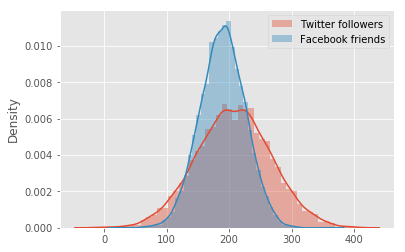

In [30]:
# Distribution plot of both normal distributions
sns.distplot(twitter_followers, label='Twitter followers')
sns.distplot(facebook_friends, label='Facebook friends')
c=plt.legend()

## The Standard Normal Distribution
To compare or re-map values of a normal distribution, we need to calculate the z-scores. All z-scores fall on the standard normal distribution, with a mean of 0 and a standard deviation of 1:

$$z=\frac{x-\mu}{\sigma}$$

To map back to the original value (in this case Facebook friends or Twitter followers):

$$x=z\cdot\sigma+\mu$$ 

In [31]:
# Calculate the z-scores for Twitter followers
z_scores_twitter = stats.mstats.zscore(twitter_followers)
z_scores_twitter[:12]

array([-0.81626189, -0.36144186, -1.5319557 ,  0.62988389,  0.76645517,
       -0.04434214, -0.44508729, -0.75734605, -0.2079697 ,  1.76187494,
       -0.4460321 ,  0.39304916])

In [32]:
# Calculate the z-scores for Facebook friends
z_scores_facebook = stats.mstats.zscore(facebook_friends)
z_scores_facebook[:12]

array([-0.25396364,  0.17222941,  1.93546459,  1.65832368,  0.35972041,
       -1.90004687,  0.47770488,  0.1952715 ,  0.76446955, -2.03520236,
        2.5256431 , -1.67757832])

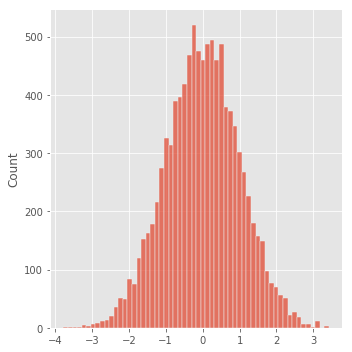

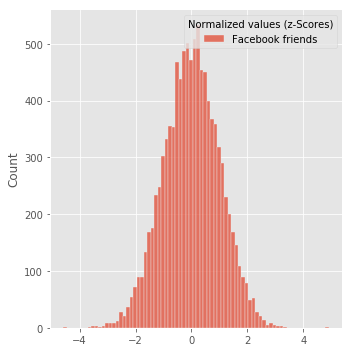

In [33]:
# Distribution plot of the normalized distributions
sns.displot(z_scores_twitter, label='Twitter followers')
sns.displot(z_scores_facebook, label='Facebook friends')
c=plt.legend(title='Normalized values (z-Scores)')

## Mapping to other distributions
Now we have our normalized distributions, we can do some mapping from one to the other. Let's say I wanted to know roughly the equivalent of Facebook friends, given a number of Twitter followers. I can calculate this by using the Standard Normal Distribution (z scores).

In [34]:
# First calculate the z score for my number of Twitter followers
me_twitter_followers = 92.0
me_twitter_zscore = (me_twitter_followers - twitter_mu) / twitter_sigma
me_twitter_zscore

-1.9333333333333333

In [35]:
# Than map the z score to a Facebook friends equivalent
me_equiv_facebook_friends = me_twitter_zscore * facebook_sigma + facebook_mu
me_equiv_facebook_friends

120.4

## Data

In [36]:
#We use a fictional data set of 10000 averge number of Facebook friends.
facebook_mu = 190.0
facebook_sigma = 36.0
facebook_friends = np.random.normal(facebook_mu, facebook_sigma, 10000)

# show first 12 samples
facebook_friends[:12]

array([165.74565601, 176.89209335, 200.0059971 , 173.99245707,
       181.74641309, 221.42089546, 222.64052844, 165.6272279 ,
       184.77757697, 175.36099527, 154.67623462, 181.30484433])

## Using the Probability Density Function
The total area under the Probability Density Function (pdf) is always 1.0. Roughly 68% of the values is within 1 standard deviation from the mean. About 95% falls within two standard deviations. We can determine the probability of finding a given value in the distribution by using the pdf. 

Let's say someone's got 227 Facebook friends. What is the probability of having this or less number of Facebook friends?

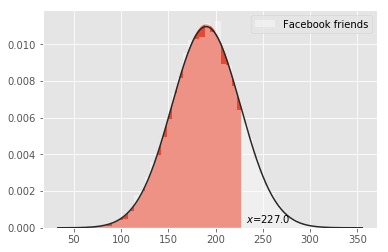

In [37]:
# First take a look at the pdf and especially the green area under
# the curve containing the probability of 227 Facebook friends or less.
x = 227.0
sns.distplot(facebook_friends, label='Facebook friends', kde=False, 
             fit=stats.norm, color='w')
plt.text(x+5, .0003, '$x$='+str(x))

x_plot = np.linspace(min(facebook_friends), x, 1000)
y_plot = stats.norm.pdf(x_plot, facebook_mu, facebook_sigma)
plt.fill_between(x_plot,  y_plot)
c=plt.legend()

In [38]:
# To calculate the probability, we need the z score.
zscore = (x - facebook_mu) / facebook_sigma
zscore

1.0277777777777777

In [39]:
# Calculate the probability by calling stats.norm.cdf
# This is a computational z table lookup
p = stats.norm.cdf(zscore)
p

0.8479728141176333

So this means the probability of people having 227 Facebook friends or less is about 85%. Since the area under the curve adds up to 1, we can say that the probability of people having a value more than 227 Facebook friends is $1-p$.

In [40]:
# Probability of having a value more than 227
1 - p

0.15202718588236674

## From probability back to the actual value
Let's assume we have a 21% chance of having a certain number of Facebook friends or more. What is the minimum number of Facebook friends we have in this case?

In [41]:
# We use the ppf function (inverse cdf) - from probability to z score
p = 1 - .21
z = stats.norm.ppf(p)
z

0.8064212470182404

In [42]:
# From z score to number of Facebook friends
x = z * facebook_sigma + facebook_mu
x

219.03116489265665

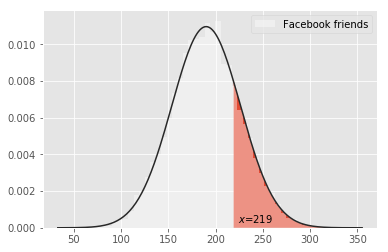

In [43]:
# The green area under the curve containing the probability 
# of (roughly) 206 Facebook friends or more.
sns.distplot(facebook_friends, label='Facebook friends', kde=False, 
             fit=stats.norm, color='w')
plt.text(x+5, .0003, '$x$='+str(int(x)))

x_plot = np.linspace(x, max(facebook_friends), 1000)
y_plot = stats.norm.pdf(x_plot, facebook_mu, facebook_sigma)
plt.fill_between(x_plot,  y_plot)
c=plt.legend()

## Calculate probability in between two values
What is the probability of people having between 120 and 170 Facebook friends?

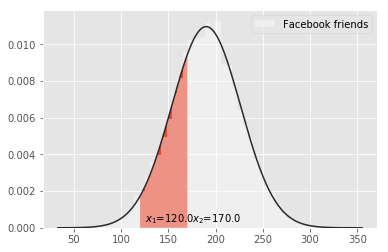

In [44]:
# We want to know the proportion of the green area under the curve.
x1 = 120.0
x2 = 170.0
sns.distplot(facebook_friends, label='Facebook friends', kde=False, 
             fit=stats.norm, color='w')
plt.text(x1+5, .0003, '$x_1$='+str(x1))
plt.text(x2+5, .0003, '$x_2$='+str(x2))

x_plot = np.linspace(x1, x2, 1000)
y_plot = stats.norm.pdf(x_plot, facebook_mu, facebook_sigma)
plt.fill_between(x_plot,  y_plot)
c=plt.legend()

In [45]:
# First we need the z score of x1
z1 = (x1 - facebook_mu) / facebook_sigma
z1

-1.9444444444444444

In [46]:
# Then we calculate the probability for value x1 or less
p1 = stats.norm.cdf(z1)
p1

0.025920939357843

In [47]:
# Now we calculate the z score for x2
z2 = (x2 - facebook_mu) / facebook_sigma
z2

-0.5555555555555556

In [48]:
# and agian the probabilty for value x2 or less
p2 = stats.norm.cdf(z2)
p2

0.28925736075397196

In [49]:
# So the probability of having between x1 and x2 Facebook friends is
# the probability having x2 minus the probability having x1
p2 - p1

0.26333642139612895

## Data
We take as our population a tetrahedral (four sided) die.

In [50]:
# One throw leads to one of four outcomes
data = np.array([1.0, 2.0, 3.0, 4.0])
data

array([1., 2., 3., 4.])

In [51]:
# Calculate the population mean
population_mu = data.mean()
population_mu

2.5

In [52]:
# Calculate the standard deviation of the population
population_sigma = data.std(ddof=0)
population_sigma

1.118033988749895

## Illustration of the Central Limit Theorem
The Central Limit Theorem (CLT) states, if we take the mean of a large number of independent samples, the sampling distribution will aproximate a normal distribution, regardless of the shape of the underlying distribution. Let's illustrate this by sampling the mean of two throws ($n=2$) with the tetrahedral die.

In [53]:
# Let's find out the number of possible outcomes with a sample size 2
possible_outcomes = 4**2
possible_outcomes

16

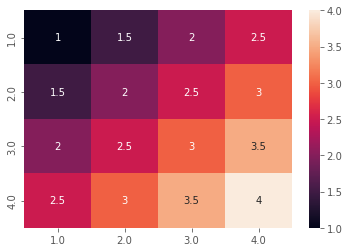

In [54]:
# Create a dataframe with the mean of all possible outcomes
mean_outcome_matrix = pd.DataFrame(index=data, dtype='float64', columns=data )

for x in data:
    for y in data:
        mean_outcome_matrix[x][y] = np.mean([x,y])

# Below you see a heatmap of the mean of all possible outcomes
p=sns.heatmap(mean_outcome_matrix, annot=True)

In [55]:
# Now get the mean of all possible mean outcomes
sample_mean = mean_outcome_matrix.mean().mean()
sample_mean

2.5

In [56]:
# Note the mean of all possible mean outcomes 
# is exactly the same as the population mean!
population_mu == sample_mean

True

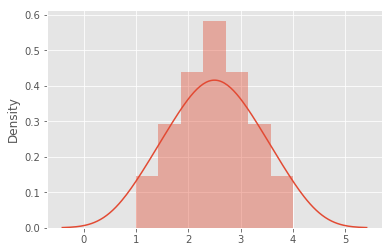

In [57]:
# Below a plot the sampling distribution of all possible mean outcomes
# Note that it's perfectly normal
diff_val_count = mean_outcome_matrix.stack().value_counts().count()
p=sns.distplot(mean_outcome_matrix.stack(), bins=diff_val_count)

## The Standard Error
The standard deviation of the sampling distribution is called the standard Error (SE).

In [58]:
# Calculate the standard error (SE) of all possible mean outcomes
mean_outcomes_SE = mean_outcome_matrix.stack().std(ddof=0)
mean_outcomes_SE

0.7905694150420949

In [59]:
# If we now calculate the ratio of sigma to SE
# we see it is the square root of 2
ratio_sigma_SE = population_sigma / mean_outcomes_SE
ratio_sigma_SE

1.414213562373095

In [60]:
# So if we square this ratio we get... our sample size (approximately)
ratio_sigma_SE ** 2

1.9999999999999996

This means that sigma $\sigma$ divided by the standard error $SE$ is the square root of our sample size $n$:

$$\frac{\sigma}{SE}= \sqrt{n}$$

Also means we can calculate the Standard Error as follows:

$$SE=\frac{\sigma}{\sqrt{n}}$$


## Data
We use a random sample of social media influence scores from the service [Klout.com](http://klout.com/ "Klout scores") as presented in Udacity's [Intro to Inferential Statistics](https://www.udacity.com/course/ud201). Of a population of 620+ milion scores we got a sample size $n=1048$.

In [61]:
# Load the data from a csv file
data = pd.read_csv('./data/klout-scores.csv', header=None, names=['scores'])
data.head()

      scores
0  25.104179
1  60.908747
2  23.222238
3  51.553491
4  22.629690

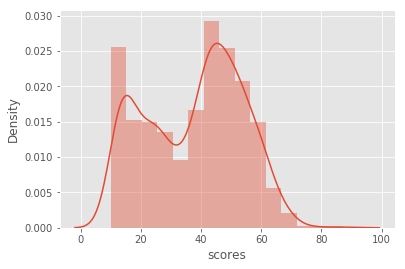

In [62]:
# Plot the sample and note the bimodal distribution shape
# The first peak are social media consumers, second peak influencers
p=sns.distplot(data.scores)

In [63]:
# Sample size
n = data.scores.count()

# The confidence coefficient
confidence_coef = .95

# The alpha level
alpha = 1. - confidence_coef

## Confidence Interval
If we want to estimate a population parameter (mean, proportion, standard deviation) from a sample statistic, we can never be sure of our outcome. But we can give some level of confidence of our prediction; the confidence interval (CI). We use the following symbols to depict parameters and statistics.

|   |mean|proportion|std dev|   |
|---|:---:|:---:|:---:|---|
|population|$\mu$|$p$|$\sigma$|parameters|
|sample|$\bar{x}$|$\hat{p}$|$s$|statistics|

Let's calculate 95% the confidence interval of the sample mean of Klout Scores. For large samples we can solve the following inequality with an alpha level of $\alpha=.05$.

$$\bar{x}-z_{\alpha/2}\cdot\frac{\sigma}{\sqrt{n}}\lt\mu_{estimator}\lt\bar{x}+z_{\alpha/2}\cdot\frac{\sigma}{\sqrt{n}}$$ 

In [64]:
# First we need our sample mean
# This is called the point estimate
klout_xbar = data.scores.mean()
klout_xbar

37.719054832538156

In [65]:
# We also need the standard error of the sample
# Since our sample size is large (> 30) we can use
# the sample standard deviation as an approximation of sigma
klout_s = data.scores.std()
klout_s

16.04431497904899

In [66]:
# The we need to find the z score to calculate the
# lower and upper bound of our confidence interval
# This is called the critical value
critical_value = stats.norm.ppf(alpha / 2) * -1.
critical_value

1.959963984540054

In [67]:
# An easier way to get the critical values calling scipy.stats
# interval function. The alpha .95 being a littbe bit misleading since
# it is not our alpha but our confidence coefficient
zscore_interval = stats.norm.interval(alpha=confidence_coef)
zscore_interval

(-1.959963984540054, 1.959963984540054)

In [68]:
# We need the standard error to calculate the bounds
klout_SE = klout_s / math.sqrt(n)
klout_SE

0.49561054484656264

In [69]:
# Calculate the lower and upper bound Klout Score 
# for the confidence interval
klout_CI_mean_lower = klout_xbar - critical_value * klout_SE
klout_CI_mean_upper = klout_xbar + critical_value * klout_SE
klout_CI_mean_lower, klout_CI_mean_upper

(36.74767601428062, 38.69043365079569)

## So what does it all mean?
A confidence interval is a 'parameter catcher'. In this case we try to catch the real population mean from a sample by declaring a confidence interval. This mean we are 95% sure that the real population mean of Klout Scores lies somewhere fixed between 36.75 and 38.69.

Klout.com states their mean score is 40, so we did not catch the true population mean parameter. Since our calculations seems to be correct, this could mean that:
- Maybe our sample mean falls way below the population mean. Note we we're only 95% confident.
- Maybe Klout's communication on the average score is simplified to an easy to remember value of 40.

## The effect of sample size
Sample size effects the bounds of the confidence interval. The smaller the sample, the less confident we are, so the wider the confidence interval. Let's try this with a random sample from the Klout Score data of $n=50$.

In [70]:
# Let's create a sample of 50 random Klout Scores
n_50 = 50
data_50 = data.iloc[np.random.choice(data.index, n_50)]
data_50.head()

        scores
522  36.061431
949  53.667544
798  54.914344
536  51.549201
66   41.191211

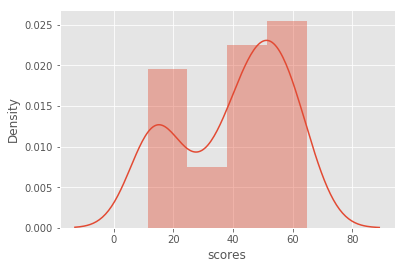

In [71]:
# Plot the sample and note a similar bimodal distribution shape
p=sns.distplot(data_50.scores)

In [72]:
# Get the point estimate
klout_50_xbar = data_50.scores.mean()
klout_50_xbar

40.288357682800005

In [73]:
# Get the sample standard deviation as an approximation of sigma
klout_50_s = data_50.scores.std()
klout_50_s

17.73868194833097

In [74]:
# Calculate the standard error for this sample size
klout_50_SE = klout_50_s / math.sqrt(n_50)
klout_50_SE

2.5086284589952457

In [75]:
# Calculate the lower and upper bound Klout Score 
# for the confidence interval of our sample of n=50
klout_50_CI_mean_lower = klout_50_xbar - critical_value * klout_50_SE
klout_50_CI_mean_upper = klout_50_xbar + critical_value * klout_50_SE
klout_50_CI_mean_lower, klout_50_CI_mean_upper

(35.37153625257711, 45.2051791130229)

With this sample size, we are 95% sure that the population mean lies within the range of *klout_50_CI_mean_lower* to *klout_50_CI_mean_upper*. Although this confidence interval does catch the mean parameter, it has also a much wider range. 

## Data
In the example we take a random sample of 25 housing prices in our neighbourhood and compare them against the average price of a house in the whole country.

In [76]:
# data = np.random.random_sample(25) * 360000 + 100000 / floor it
housing_prices = pd.Series(
    [319711.,  289066.,  212512.,  195347.,  245589.,  418577., 
     301112.,  327251.,  434408.,  224529.,  450276.,  423406.,
     230321.,  275374.,  215945.,  209971.,  322661.,  292517.,
     378317.,  194028.,  347261.,  104542.,  231457.,  335174.,  
     369656.])
housing_prices.head()

0    319711.0
1    289066.0
2    212512.0
3    195347.0
4    245589.0
dtype: float64

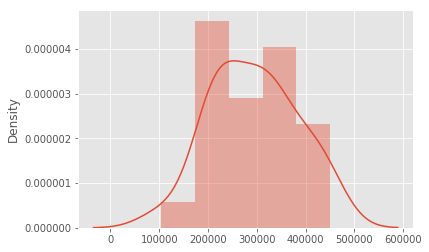

In [77]:
sns.distplot(housing_prices)
plt.show()

## Hypothesis
We want to know if there is a significant difference in the mean housing price, compared to the average price of a house in our country. The latter has a mean of $\mu=289.100$. We choose as our test criterium an alpha level of 5%. So our hypothesis states:

|Hypothesis||$\alpha = .05$|
|---:|:---:|---|:---|
|$H_0:$|$\bar{x} = \mu$|There is no significant difference in mean housing price|
|$H_a:$|$\bar{x} \neq \mu$|There is a significant difference in the mean housing price|


In [78]:
# The mean housing price is a given
mu = 289100.
mu

289100.0

In [79]:
# The sample statistics
n = housing_prices.count()
xbar = housing_prices.mean()
s = housing_prices.std(ddof=1)
n, xbar, s

(25, 293960.32, 88348.43221383916)

In [80]:
# Show the mean difference
xbar - mu

4860.320000000007

It looks like the housing prices in our neighbourhood are slightly higher than the average price of a house in the whole country. But is a  4860.32 difference significant? 

## The t-distribution
Since we don't know the standard deviation of the population, we can't use the the standard normal distribution to perform our hypothesis test. If we don't know this population parameter we use the t-distribution. The shape of the t-distribution is closely related to the degrees of freedom we have in the dataset. For a series (like we have here) this is $n-1$. Below a plot of the difference in shape from the normal distribution.

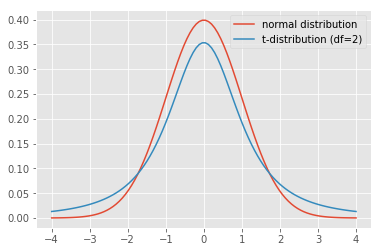

In [81]:
# Plot the normal distribution
samples = 100
dof = 2
x_plot = np.linspace(-4, 4, samples)
y_plot = stats.norm.pdf(x_plot, 0, 1)
plt.plot(x_plot, y_plot)

x_plot = np.linspace(-4, 4, samples)
y_plot = stats.t.pdf(x_plot, dof)
plt.plot(x_plot, y_plot)

# Show legend
plt.legend(['normal distribution', 't-distribution (df=2)'])
plt.show()

## Effect of increased degrees of freedom
The t-distribution tends to grow towards the normal distribution when the degrees of freedom increase. If we have a sample size bigger than $n=30$, the differences between the t and normal distribution are very small. Below a projection of the effect on the t-distribution while increasing the degrees of freedom from 1, 4, 14 to 29.

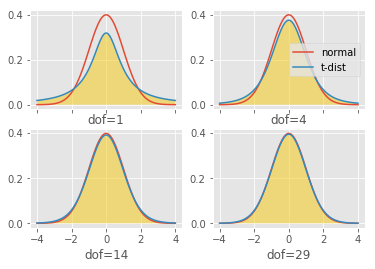

In [82]:
f, (ax1, ax2) = plt.subplots(2, 2, sharex=True)
axes = [ax1[0], ax1[1], ax2[0], ax2[1]]
ax = 0

samples = 100
degrees_of_freedom = [1, 4, 14, 29]

for dof in degrees_of_freedom:
    x_plot = np.linspace(-4, 4, samples)
    y_plot = stats.norm.pdf(x_plot, 0, 1)
    axes[ax].plot(x_plot, y_plot)

    y_fill = stats.t.pdf(x_plot, dof)
    axes[ax].fill_between(x_plot,  y_fill, alpha=.5, facecolor=fill_color) 
    
    y_plot = stats.t.pdf(x_plot, dof)
    axes[ax].plot(x_plot, y_plot)
    axes[ax].set_xlabel('dof=' + str(dof))
    
    ax += 1  
    
axes[1].legend(['normal', 't-dist'])
plt.show()

## The one-sample t-test
Let's find out what out t-statistic related to our sample mean. We use the follwing formula:

$$t=\frac{\bar{x}-\mu}{s\cdot\sqrt{n}}$$

In [83]:
# Calculate the t-statistic for the sample mean
se = s / math.sqrt(n)
t_statistic = (xbar - mu) / se
t_statistic

0.2750654356964737

In [84]:
# What is the probability of getting this mean?
p = stats.t.sf(t_statistic, dof) * 2. # two-sided test 
p

0.7852162672614891

In [85]:
# To test our alternative hypothesis
alpha = .05
p < alpha / 2 #two sided

False

So we fail to reject the null hypothesis. A mean difference of 4860.32 in housing prices between our neigbourhood and the whole country is not significant.

In [86]:
# To perform a t-test more quickly, we can use scipy.stats ttest_1samp
# for a one-sample t-test. The function returns the t-statistic and 
# the p-value in one single call. Slightly different results, but close
t_statistic, p = stats.ttest_1samp(housing_prices, mu)
t_statistic, p

(0.2750654356964736, 0.7856201417078766)

## Cohen's d effect size
Cohen's d is an effect size measure. According to Wikipedia, in statistics, an [effect size](http://en.wikipedia.org/wiki/Effect_size) is a quantitative measure of the strength of a phenomenon. Cohen's d is the standardized mean difference that measures the distance between two means in standard units (standard deviations). The larger the result (positive or negative), the larger the effect. Rule of thumb; small (0.2), medium (0.5) and large (0.8). Click the link to see a great interactive visualization on [Interpreting Cohen's d effect size](http://rpsychologist.com/d3/cohend/). The formula for Cohen's d is as follows:


$$Cohen's\ d=\frac{\bar{x}-\mu}{s}$$

In [87]:
# Calculate Cohen's d
d = (xbar - mu) / s
d

0.05501308713929473

This is a very small effect, acording to our rule of thumb stated above. The two mean are only 0.055 standard deviations apart.

## Confidence interval
In addition to our test result, we want to calculate an interval in which our population parameter will probably lie. In this case the true average housing price in our neighbourhood. With the t-statistic we just calculated, we can calculate a 95% confidence interval.

In [88]:
# Calculate the 95% confidence interval
dof = n - 1
t_critical = abs(stats.t.ppf(alpha / 2, dof)) # two sided
margin_of_error = t_critical * se

CI_lower =  xbar - margin_of_error
CI_upper =  xbar + margin_of_error
CI_lower, CI_upper

(257491.87956635334, 330428.7604336467)

This means that we are for 95% certain that the true mean housing price in our neighborhood lies between 257.491 and 330.428.

## Data
We use two samples of the same subjects, in this case a group of 19 randomly selected women walking on high heels in one sample and flat shoes in another. The samples show the number of steps taken in 30 days for each woman in the group.

In [89]:
high_heels = pd.Series(
    [189158.,  192110.,  176194.,  156349.,  161981.,  152096.,
     168058.,  156401.,  174939.,  170711.,  170485.,  150565.,
     167770.,  157289.,  191459.,  160661.,  190667.,  184006.,  174503.])
flat_shoes = pd.Series(
    [188777.,  196981.,  190510.,  184603.,  192341.,  197897.,
     154040.,  168098.,  192263.,  154085.,  176084.,  189249.,
     176291.,  151454.,  198118.,  162959.,  167480.,  159884.,  184386.])

data = pd.DataFrame({'high': high_heels, 'flat': flat_shoes})
data.head()

       high      flat
0  189158.0  188777.0
1  192110.0  196981.0
2  176194.0  190510.0
3  156349.0  184603.0
4  161981.0  192341.0

In [90]:
# The violin plot above shows the median, quartiles, IQR and 
# probability density function (kernel density estimation) 
# for both groups
data.describe()

                high           flat
count      19.000000      19.000000
mean   170810.631579  178184.210526
std     13748.423232   16113.058647
min    150565.000000  151454.000000
25%    158975.000000  165219.500000
50%    170485.000000  184386.000000
75%    180100.000000  191386.500000
max    192110.000000  198118.000000

## Hypothesis
We want to know if there is a significant difference in the mean steps taken in 30 days for women wearing high heels and the same group wearing flat shoes. While walking on high heels, the women scored a mean average of $\bar{x}_h=170810.63$. On flat shoes the mean average is $\bar{x}_f=178184.21$ We choose as our test criterium an alpha level of 5%. So our hypothesis states:

|Hypothesis||$\alpha = .05$|
|---:|:---:|---|:---|
|$H_0:$|$\mu_h = \mu_f$|There is no significant difference in mean steps between groups|
|$H_a:$|$\mu_h \neq \mu_f$|There is a significant difference in mean steps between groups|

Note that the hypothesis is written to denote the whole population, not just the sample.

In [91]:
# Take the difference of each subject
data['difference'] = data.high - data.flat
data.head()

       high      flat  difference
0  189158.0  188777.0       381.0
1  192110.0  196981.0     -4871.0
2  176194.0  190510.0    -14316.0
3  156349.0  184603.0    -28254.0
4  161981.0  192341.0    -30360.0

## Conduct a t-Test for dependent means
All steps below are actually the same as for a one sample t-test conducted on a sample of mean differences.

In [92]:
# Calculate the point estimate (mean difference)
point_estimate = data['difference'].mean()
point_estimate

-7373.578947368421

In [93]:
# Calculate the sample standard deviation of the difference
s = data.difference.std()
s

19471.738275755768

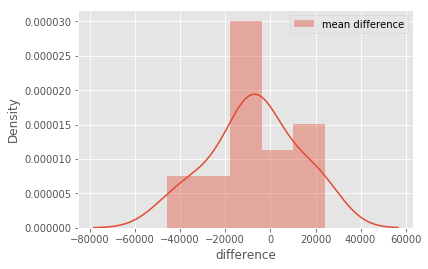

In [94]:
# Show the mean difference distribution
sns.distplot(data.difference, label='mean difference')
plt.legend()
plt.show()

In [95]:
# Calculate the t-statistic with the point estimate
n = data.high.count() # the same for both samples
se = s / math.sqrt(n) # standard error
t = point_estimate / se
n, se, t

(19, 4467.123126268016, -1.6506325746898667)

In [96]:
# So what is the probability of getting this mean difference?
dof = n - 1
p = stats.t.sf(abs(t), dof) * 2 # two sided
p

0.11615318918022235

In [97]:
# To test our alternative hypothesis
alpha = .05
p < alpha / 2 # two sided

False

We fail to reject the null. There is no statistical significant difference in the mean differences between steps taken on high heels or flat shoes.

In [98]:
# A quicker way to perform a dependent t-test is to call the scipy
# function ttest_rel on both samples to get our t-statistic and 
# p value
t_statistic, p = stats.ttest_rel(data.high, data.flat)
t_statistic, p

(-1.6506325746898667, 0.11615318918022235)

## Confidence interval

In [99]:
# Calculate t-critical to use with our confidence interval
t_critical = abs(stats.t.ppf(alpha / 2, dof)) # two sided
t_critical

2.10092204024096

In [100]:
# Calculate the confidence interval
margin_of_error = se * t_critical
CI_lo = point_estimate - margin_of_error
CI_hi = point_estimate + margin_of_error
CI_lo, CI_hi

(-16758.656379815, 2011.4984850781557)

We are confident that the true mean difference lies somewhere between -16758 and 2011. This confidence interval crosses 0, so a true mean difference could be 0 (meaning no difference at all).

## Data
We have collected samples of the wine prices of two fictitious online liquorstores, bestliqs.com and cheapliq.com.

In [101]:
bestliqs_wine_prices = pd.Series(
    [9, 5, 6, 11, 8, 5, 7, 13, 12, 13, 9, 8, 10, 6, 11, 9, 7, 12])
cheapliq_wine_prices = pd.Series(
    [11, 10, 12, 9, 8, 13, 14, 15, 12, 11, 13, 8, 9, 11])

data = pd.DataFrame({'bestliqs': bestliqs_wine_prices, 
                     'cheapliq': cheapliq_wine_prices})
data.describe()

        bestliqs   cheapliq
count  18.000000  14.000000
mean    8.944444  11.142857
std     2.645134   2.178819
min     5.000000   8.000000
25%     7.000000   9.250000
50%     9.000000  11.000000
75%    11.000000  12.750000
max    13.000000  15.000000

## Question and hypothesis
Well, it looks like cheapliq.com isn't as cheap as they say. However, is the difference statistically significant? We don't want to spend too much on the first batch of wine for our new cellar. Which online liquor store to choose if we want to decide on the lowest mean wine price?

|Hypothesis||$\alpha = .05$|
|---:|:---:|---|:---|
|$H_0:$|$\mu_{best} = \mu_{cheap}$|There is no significant difference in mean wine prices|
|$H_a:$|$\mu_{best} \neq \mu_{cheap}$|There is a significant difference in mean wine prices|

## Independent Samples t-test

In [102]:
# First find out what the mean prices are
xbar_best = data.bestliqs.mean()
xbar_cheap = data.cheapliq.mean()
xbar_best, xbar_cheap

(8.944444444444445, 11.142857142857142)

In [103]:
# Then we get the sample standard devation for each liquor store
s_best = data.bestliqs.std(ddof=1)
s_cheap = data.cheapliq.std(ddof=1)
s_best, s_cheap

(2.6451336499586917, 2.1788191176076888)

## The Standard Error of the Mean
To calculate the standard error of the mean combined for both independent wine price samples, we need to use the following formula:

$$sem=\sqrt{\frac{s_{best}^2}{n_{best}}+\frac{s_{cheap}^2}{n_{cheap}}}$$


In [104]:
# Calculate the standard error of the mean combined
n_best = data.bestliqs.count()
n_cheap = data.cheapliq.count()
sem = math.sqrt(s_best ** 2 / n_best + 
                s_cheap ** 2 / n_cheap)
sem

0.8531100847677227

In [105]:
# Now calculate the t-statistic
t = (xbar_best - xbar_cheap) / sem
t

-2.5769390582356815

In [106]:
# Get the criotical values for a two-tailed test at alpha .05
alpha = .05
dof = n_best + n_cheap - 2  # for both samples combined
t_critical = stats.t.ppf(alpha / 2, dof)  # two sided
t_critical

-2.042272456301238

## Hypothesis testing

In [107]:
# Test our alternative hypothesis
t < t_critical or t > -t_critical

True

In [108]:
# Another way to test the alternative hypothesis by comparing 
# the probability of getting this mean with the alpha level.
p = stats.t.sf(abs(t), dof) * 2  # two sided
p

0.01512946515275131

In [109]:
p < alpha

True

Based on these result, we conclude that the difference in mean wine price is not due to random chance or variation in the samples. Therefor we will reject the null hypothesis. Bestliqs.com is, on average, the better choice for the better wine price. Note there is a 5% chance (1 - alpha) on commiting a type I error in which the null hypothesis is true, but was rejected.

## Using scipy.stats or statsmodels

In [110]:
# A quicker way to get these results is to call scipy stats
# ttest_ind on both samples for unequal variances
# equal_var False makes it effectively Welch's t-test
t_statistic, p = stats.ttest_ind(data.bestliqs, data.cheapliq.dropna(), 
                                 equal_var=False)
t_statistic, p

(-2.576939058235681, 0.015153519382495312)

In [111]:
# Another alternative is using Statsmodels
import statsmodels.api as sm
t_statistic, p, dof = sm.stats.ttest_ind(data.bestliqs, data.cheapliq.dropna(), 
                   alternative='two-sided', usevar='unequal')
t_statistic, p, dof

AttributeError: module 'pandas' has no attribute 'Panel'

## Data
Here we create two samples of different sample size. We want to know if the sample means are significantly different.

In [ ]:
sample_a = np.array([4.9, 6.2, 1.0, -4.8, 2.2, 5.4])
sample_b = np.array([2.8, 6.9, 8.4])

In [ ]:
# Find the mean for both samples
xbar_a = sample_a.mean()
xbar_b = sample_b.mean()

xbar_a, xbar_b

## Hypothesis
Is there a statistical significant difference between the two sample means at an alpha level of .05?

|Hypothesis||$\alpha = .05$|
|---:|:---:|---|:---|
|$H_0:$|$\mu_{a} = \mu_{a}$|There is no significant difference between a and b|
|$H_a:$|$\mu_{b} \neq \mu_{b}$|There is a significant difference between a and b|

## Sum of Squares
First we need to find the sum of squares from both samples. We do this by summing all the differences from the mean in the sample, then square them. The following formula applies:

$$SS=\sum(x_i-\bar{x})^2$$

In [ ]:
# Find the sum of squares for both samples
ss_a = np.sum((sample_a - xbar_a) ** 2)
ss_b = np.sum((sample_b - xbar_b) ** 2)

ss_a, ss_b

## Pooled Variance
Since the sample size between a and b is different, we can use the pooled variance to account for these difference in calculations. The following formula applies:

$$S_p^2=\frac{SS_a+SS_b}{df_a + df_b}$$

In [ ]:
# Calculate the Degrees of Freedom for both samples
n_a = len(sample_a)
n_b = len(sample_b)
dof_a = n_a - 1
dof_b = n_b - 1

dof_a, dof_b

In [ ]:
# Calculate the Pooled Variance
Sp2 = (ss_a + ss_b) / (dof_a + dof_b)
Sp2

## Standard Error
Now we can calculate the Standard Error by using the Pooled Variance instead of the individual variance. The following formula applies:

$$sem=\sqrt{\frac{S_p^2}{n_a}+\frac{S_p^2}{n_b}}$$

In [ ]:
# Calculate the Standard Error of the Mean
sem = np.sqrt(Sp2 / n_a + Sp2 / n_b)
sem

## The t-Statistic
The t-statistic for the mean difference between these samples is calculated as follows:

$$t=\frac{(\bar{x}_a-\bar{x}_b)-(\mu_a-\mu_b)}{sem}$$

In [ ]:
# Calculate the t-statistic
observed_diff = xbar_a - xbar_b
expected_diff = 0  # we expect no difference between population means

t = (observed_diff - expected_diff) / sem
t

## The t-critical value
To test our hypothesis, we need to get the t-critical value.

In [ ]:
alpha = .05
t_critical = np.abs(stats.t.ppf(alpha / 2, dof_a + dof_b))  # two sided
t_critical

## Hypothesis testing

In [ ]:
# We compare our t-statistic against the t-criticalk value to test the 
# acceptance of the alternative hypothesis
-t_critical > t or t > t_critical

Since the t-statistic lies between the t-critical values of alpha, we fail to reject the null hypothesis. The mean difference from both samples is probably due to chance and therefore not statistical significant.

## Using scipy.stats or statsmodels

In [ ]:
# A quicker way to get these results is to call scipy stats
# ttest_ind on both samples
t_statistic, p = stats.ttest_ind(sample_a, sample_b)
t_statistic, p

In [ ]:
# Another alternative is using Statsmodels
t_statistic, p, dof = sm.stats.ttest_ind(sample_a, sample_b, 
                   alternative='two-sided', usevar='pooled')
t_statistic, p, dof

## Baseball data
We use baseball stats data from the [Lahman’s Baseball Database](http://www.seanlahman.com/baseball-archive/statistics) as provided by the Udacity course [Intro to Data Science](https://www.udacity.com/course/ud359).

In [ ]:
# Load the stats data from a csv file
df = pd.read_csv('./data/baseball_stats.csv')
df.head()

## Question and hypothesis
We want to know if there is a statistical significant difference in the career batting average between left-handed and right-handed players. We choose an alpha level of 5% as the significance level. We test against the hypothesis below:

|Hypothesis||$\alpha = .05$|
|---:|:---:|---|:---|
|$H_0:$|$\mu_{R} = \mu_{L}$|There is no significant difference between left and right handedness|
|$H_a:$|$\mu_{R} \neq \mu_{L}$|There is a significant difference between left and right handedness|

## Some data wrangling

In [ ]:
# Get the appropriate samples from the dataframe
# Filter out the batting averages of 0.0 (pitchers assumed)
left_handed_avg  = df[(df['handedness'] == 'L') & (df['avg'] != 0)]['avg']
right_handed_avg = df[(df['handedness'] == 'R') & (df['avg'] != 0)]['avg']

left_handed_avg.count(), right_handed_avg.count()

In [ ]:
# Plot the distributions
sns.distplot(left_handed_avg)
sns.distplot(right_handed_avg)
plt.show()

## Welch's t-Test
This t-test is a more generic hypothesis test for independent samples, based on Student's t-test. The difference with the Student's t-test is that we account for sample size and variance differences. If we set equal_var to False in the scipy stats ttest_ind, the function performs the Welch's t-test instead of the Student's t-test. The following formula applies:

$$t=\frac{(\bar{x}_a-\bar{x}_b)-(\mu_a-\mu_b)}{\sqrt{\frac{s_a^2}{n_a}+\frac{s_b^2}{n_b}}}$$


Note that the variance of $a$ and $b$ are used, not the pooled variance.

In [ ]:
# Perform Welch's t-test (equal_var=False)
t, p = stats.ttest_ind(left_handed_avg, right_handed_avg, equal_var=False)
t, p

This function assumes we want to perform a two-sided t-test. For a one-sided t-test use $\frac{1}{2}p$ since it is only true for one side of the distribution.

## Hypothesis testing

In [ ]:
# Test if we can reject the null hypothesis
alpha = .05
p < alpha

There seems to be a statistical significant difference between left and right handed players. We are 95% confident that the difference is not due to random chance.

## Non-normal distribution

In [ ]:
# Create a set with an obvious non-normal distribution
data = pd.Series([1,1,0,1,2,2,3,2,1,3,3,2,8,2,1,6,2,1,1,2,2,1,3,2,1,
                  2,3,6,2,3,2,2,1,2,2,3,2,1,2,3,2,3,2,3,1,6,1,8,1,1])
data.describe()

In [ ]:
# Plot the non-normal distribution
sns.distplot(data)
plt.show()

In [ ]:
# The null hypothesis states the data was drawn from a normal distribution. 
# It returns the w-statistic and the probability that this statistic 
# came from a normal distribution (p value)
w, p = stats.shapiro(data)
w, p

In [ ]:
# Test the null hypothesis with 5% alpha
alpha = .05
p > alpha

Since this p value is much larger than the significance level, we reject the null hypothesis that this sample comes from a normal distribution.

## Normal distribution

In [ ]:
# Let perform the same test on a random generated normal distribution
mu, sigma, n = 0, .1, 50
data = np.random.normal(mu, sigma, n)
data

In [ ]:
# Plot the more 'normal' distribution
sns.distplot(data)
plt.show()

In [ ]:
# The Shapiro-Wilk test tests the null hypothesis that the data 
# was drawn from a normal distribution.
w, p = stats.shapiro(data)
w, p

In [ ]:
# Test the null hypothesis with 5% alpha
alpha = .05
p > alpha

Since this p value is much larger than the significance level, we retain the null hypothesis that this sample comes from a normal distribution.

## Testing Multiple Independent Samples
If we want to test for significance in mean differences between more than two independent samples, we would have to perform a lot of t-tests. If, for example, we have 6 independent samples, we must conduct 15 t-tests to know what samples significantly differ from each other, as shown here in the binomial:

$$
\binom{n}{2}=\frac{n!}{2!(n-2)!}=\frac{6\cdot5\cdot4\cdot3\cdot2\cdot1}{(2\cdot1)\cdot(4\cdot3\cdot2\cdot1)}=\frac{6\cdot5}{2}=\frac{30}{2}=15
$$


That's a lot of, and even unnecessary, work. That's where ANOVA comes in. With Analysis of Variance we can test multiple independent sample sets to see if there is a significant difference between at least two samples. 

## Case
A manufacturer of electric guitar strings 'Olixir', claims to have the longest sustaining tone in the market. They conducted a comparitive test with a group of three competing brands. The guitar used in the test was the same for all tests. All strings were plucked by the same person, with the same technique and performed a number of times. The tone sustain length is measured in milliseconds. The resulting data set looks like this:

In [ ]:
# The four sample sets with guitar string sustain lengths
olixir = np.array([8021., 6947., 8411., 7593., 7781.])
ernies = np.array([7013., 6222., 7202., 6437., 5946., 6917., 6152.])
fendor = np.array([9896., 9497., 8986., 8496.])
daddar = np.array([8253., 8467., 7898., 7699., 8738., 8638.])

# Construct kernel density estimate plot
sns.kdeplot(olixir, label='olixer', shade=True)
sns.kdeplot(ernies, label='ernies', shade=True)
sns.kdeplot(fendor, label='fendor', shade=True)
sns.kdeplot(daddar, label='daddar', shade=True)

plt.legend()
plt.show()

## Grand Mean
We can compare three or more samples by finding the average squared deviation of each sample from the [grand mean](http://en.wikipedia.org/wiki/Grand_mean) of all sample groups $\bar{\bar{x}}$. The grand mean is calculated by taking all sample values and divide them by the number of samples (where $k$ is the number of groups and $n$ is the number of observations in a group and $x$ is single sample).

$$
\bar{\bar{x}}=\frac{1}{kn}\sum_{k}\sum_{n}x
$$

## Hypothesis
While Fendor seems to have the highest mean average tone sustain, is the difference compared to the other samples statistical significant or due to random chance? We state our hypothesis: If there is no statistical significant difference between any of the tested guitar strings brands at an alpha level of .05, then we fail to reject the null hypothesis.

|Hypothesis|$\alpha = .05$||
|---:|:---:|---|:---|
|$H_0:$|$\mu_o = \mu_e = \mu_f = \mu_d$|There is no significant difference between any of the brands|
|$H_a:$|$\mu_o \neq \mu_e \neq \mu_f \neq \mu_d$|There is a significant difference between at least two brands|

In [ ]:
# Calculate the grand mean and sample group means
N = np.concatenate([olixir, ernies, fendor, daddar]).size
xbar_grand = np.concatenate([olixir, ernies, fendor, daddar]).mean()

print(xbar_grand)

In [ ]:
# Calculate the group means
xbar_olixir = olixir.mean()
xbar_ernies = ernies.mean()
xbar_fendor = fendor.mean()
xbar_daddar = daddar.mean()

print(xbar_olixir, xbar_ernies, xbar_fendor, xbar_daddar, sep='\n')

## ANOVA
The [One-way Analysis of Variance](http://en.wikipedia.org/wiki/One-way_analysis_of_variance) results in a test statistic (F) which is a ratio of the 'between-group variability' and the 'within-group variability'. The between-group variability denotes the distance the group means have from each other, while the within-group variability is a measure of how wide or skinny the distribution of a group is. The larger the variance the wider the distribution.

## Between-group Variability
To calculate the between-group variability we take mean difference of each sample (SSB) in relation to the grand mean. We multiple the number of groups times the sum of the differences between the group mean and grand mean, squared:

$$
\sum n_k(\bar{x}_k-\bar{\bar{x}})^2
$$

In [ ]:
# Calculate the sum of squares between groups (SSB)
ssb_olixir = len(olixir) * np.square(xbar_olixir - xbar_grand)
ssb_ernies = len(ernies) * np.square(xbar_ernies - xbar_grand)
ssb_fendor = len(fendor) * np.square(xbar_fendor - xbar_grand)
ssb_daddar = len(daddar) * np.square(xbar_daddar - xbar_grand)

SSB = (ssb_olixir + ssb_ernies + ssb_fendor + ssb_daddar)
print(SSB)

## Within-group Variability
To calculate the within-group variability we take the sum of squares of each sample point in relation to the group mean (SSW). We sum up these differences, squared:

$$
\sum(x_i-\bar{x}_k)^2
$$

In [ ]:
# Calculate the sum of squares within groups (SSW)
ssw_olixir = np.square(olixir - xbar_olixir).sum()
ssw_ernies = np.square(ernies - xbar_ernies).sum()
ssw_fendor = np.square(fendor - xbar_fendor).sum()
ssw_daddar = np.square(daddar - xbar_daddar).sum()

SSW = ssw_olixir + ssw_ernies + ssw_fendor + ssw_daddar
print(SSW)

## F-statistic
Now we have the sum of squares for both within-group and between-group, we can calculate the F-statistic. For this we need the degrees of freedom for between-groups (k-1) and within-groups (N-k). We then calculate the mean square between groups (MSB) and the mean square within groups (MSW). The complete formula for calculating the F-statistic is shown here:

$$
F=\frac{\sum n_k(\bar{x}_k-\bar{\bar{x}})^2/(k-1)}{\sum(x_i-\bar{x}_k)^2/(N-k)}=\frac{SSB/dfB}{SSW/dfW}=\frac{MSB}{MSW}
$$


In [ ]:
# Calculate the degrees of freedom
k = 4        # Number of sample groups
dfB = k - 1  # Degrees of freedom between groups
dfW = N - k  # Degrees of freedom within groups
print(dfB, dfW, sep=', ')

In [ ]:
# Calculate the Mean squared difference
MSB = SSB / dfB 
MSW = SSW / dfW 
print(MSB, MSW, sep='\n')

In [ ]:
# Calculate the F-statistic
F = MSB / MSW
print(F)

## Hypothesis Testing
We test the hypothesis by comparing the calculated f-statistic against the F-critical value for an alpha level and the degreed of freedom between and within groups. The F-test is always a one-sided test against an alpha level on the F-distribution.

In [ ]:
# Find the F-critical value for alpha level .05
F_critical = stats.distributions.f.ppf(1 - .05, dfB, dfW)
print(F_critical)

In [ ]:
# Plot the F-Distribution for dfB and dfW
x_plot = np.linspace(0, 5, 250)
y_plot = stats.distributions.f.pdf(x_plot, dfB, dfW)
plt.fill_between(x_plot, y_plot, alpha=.2)
plt.plot(x_plot, y_plot)

# Plot the F-critical value at alpha .05
x_fcrit = np.linspace(F_critical, 5, 250)
y_fcrit = stats.distributions.f.pdf(x_fcrit, dfB, dfW)
plt.fill_between(x_fcrit, y_fcrit, alpha=.5)
plt.text(F_critical, .07, '$F_{critical}=$'+str(F_critical))
plt.xlabel('F-values')
plt.ylabel('Probability')
plt.show()

In [ ]:
# Test the null hypothesis
F < F_critical

Since the F-statistic is (much) larger than the F-critical value, we reject the null hypothesis. At least two of the sample groups tested are have a significant different mean.

## ANOVA with f_oneway
All the calculations shown here can be efficiently done by calling [scipy stats f_oneway](http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html), given the sample groups. The function returns the F-statistic as well as the p-value.

In [ ]:
# One-way ANOVA the convenient way
f_value, p_value = stats.f_oneway(olixir, ernies, fendor, daddar)
print(f_value)
print(p_value)

In [ ]:
# Null hypothesis test at alpha level .05
p_value > .05

## ANOVA Table
We often use and encounter [analysis of variance tables](https://onlinecourses.science.psu.edu/stat414/node/218) like this one to report our findings.

|Source|DF|SS|MS|F|P|
|:---|---:|---:|---:|---:|---:|
|Factor|3|20291819.866|6763939.955|26.653|7.688e-07|
|Error|18|4568010.498|253778.361|||
|Total|21|24859830.364||||

## Eta Squared
The effect size used to interpret the outcome of the ANOVA is called [eta squared](http://en.wikiversity.org/wiki/Eta-squared) $\eta^2$. This value is the proportion of the difference due to a treatment, in this case the guitar string brand. Like $r^2$, we use $\eta^2$ to denote how much of the difference in means is explained by the input variable. Eta squared is calculated as follows:

$$
\eta^2=\frac{\sum n_k(\bar{x}_k-\bar{\bar{x}})^2}{\sum n_k(\bar{x}_k-\bar{\bar{x}})^2+\sum(x_i-\bar{x}_k)^2}=\frac{SSB}{SSB+SSW}
$$

In [ ]:
# Calculate eta squared
eta_squared = SSB / (SSB + SSW)
print(eta_squared)

This value points out that approximately 82% of the guitar string tone sustain can be explained by the different guitar brands.